### Fandom Trends and Pecularities From AO3 Data
#### Made by: Rebekah Washburn (u1310114), Noble Ledbetter (u0967666), and Henry Brunisholz (u1276675)

### Background and Motivation
___

The world of fanfiction has been thriving for years. Many popular authors started in fanfiction, and famous novels like *Fifty Shades of Grey* by E. L. James and *After* by Anna Todd started as fan works. As the world of fanfiction and fandom has become more mainstream, sites like [Archive of Our Own (AO3)](https://archiveofourown.org) have held millions of works available for people to enjoy. Both Henry and Rebekah are interested in fanfiction and the data surround these works and are excited to analyze data AO3 specifically. While Noble, an aspiring author, is interested to see trends in the fanfiction universe. We hope to create something meaningful, like Toastystats' fandom statistics, found [here](https://archiveofourown.org/users/destinationtoast/pseuds/toastystats/works?fandom_id=87791).

**An Important Notice to Readers: Some of the included code cells were written for larger files of information, and will be unable to run correctly. Such cells will have a comment warning, and will be followed by modified cells that should allow our findings to be shown with no issue.**

## Project Objectives
___
We have successfully completed many of the objectives as presented in our project proposal draft, discovering:
- Rating does relate to popularity.
- The various measures of popularity are tightly correlated.
- Length has some relation to popularity.
- There are possible mismatches between supply and demand - for example, longer works are broadly speaking more popular but works tend to be short. 

On the skills side, we got practice with:
- cleaning and converting SQLLite to csv.
- Cutting up a large data-set into managable chunks.
- Sorting through and analyzing a new data-set, from "the wild".

## Background

Fanfiction is the term used to describe written works made by fans about and taking place in media properties - like books and movies. It has been around for a long time, longer if you count derivative works made before the advent of copyright like Virgil's Aeneid - an epic poem in the tradition of Homer's works and with many shared characters and mythical elements.

In the modern era, fanfiction is mostly released on the internet on fanfiction hosting websites like fanfiction.net, wattpad, and ArchiveOfOurOwn (AO3).

AO3 specifically is unique in that it is an **archive** meaning that the non-profit that made the site explicitly intends it to be used for preservational and even historical purposes, keeping the creative effort of fans around for years to come. In pursuing this purpose, the archive is known to have quite relaxed rules surrounding content, letting many different types of work not allowed on other sites in.

The structure of AO3 is quite different from the more commercialized websites, like Wattpad, it lacks any algorthimically generated reccomendations. Instead, users search for works using a highly detailed "tagging" system where every fanfiction has tags for fandoms, characters, relationships, and much more. This data is attached to each work, making the tags very useful for a project like this.

Finally, each work in the archive has several bits of meta-data like a title, length, and author name. In addition, there is a hit-tracker that counts how many seperate devices/IPs have viewed each work, an option for readers to like the work (called "kudos"), an option for readers to comment on each chapter of a work, and an option for readers to save or "bookmark" a work, to receive email notifications when the work updates.

### Data Description

The data we are analyzing was collected in 2020 by reddit user theCodeCat, who scraped non-user-restricted fan-works from ArchiveOfOurOwn (AO3). The data is available for download [here](https://www.reddit.com/r/datasets/comments/i254cw/archiveofourown_dataset/), and is in a SQLite3 database.

After processing, our data contained approximately 6 million fan-works, with the following information contained in three files: "not_reduced_project_info"; "reduced_chapter_text"; "tag_data". Due to the size of the last file, we ended up making a reduced version for our NLP analysis, called "top_tags". 

not_reduced_project_info contains the following data about these fan-works:
- id
- title (user entered)
- date published (user entered)
- language (user entered)
- rating (user entered)
- completion status (user entered)
- number of words
- number of hits
- number of kudos
- number of comments
- number of bookmarks
- description  (user entered)

reduced_chapter_text contains the following data for a smaller subset of works:
- id
- chapter number
- chapter text (user entered)

tag_data contains the following data for each use of a tag:  
- the story it is attached to
- the tag's id
- the tag's name
- the type of tag (relationship, warning, etc.)

### Acquistion

Acquistion was done via downloading the scrapped AO3 data provided by theCodeCat, the link in the "Data Description" section contains that data available for download.


## Cleaning

The data we aquired was already well organized and cleaned. However, we needed to convert it from an SQLite3 database into Pandas data frames. Initially, we tried to convert without learning about SQLite3. In our first milestone submission, you will see that our process to convert to data frames was longer. After our lecture on databases, we regathered our data using SQLite3. This was a much faster process - while using Pandas was taking a few hours to go through the data, grouping through SQLite3 took maybe a few minutes. The following is code from our file, "SQLite3_to_csv". It will not run properly, as I cannot include the SQLite3 file due to its size. **A note about the following code - almost all sections of code have their own import statements, as we ran the segments needed at different times, depending on the information we were currently retrieving.** 

In [ ]:
import pandas as pd
import csv
import sqlite3
conn = sqlite3.connect("organizedData.sqlite3")

all_data = pd.read_sql_query("""SELECT StoryHeaders.id, title, date, language, Language_Name, restricted, StoryHeaders.rating, 
                finished, words, hits, kudos, bookmarks, comments, description, Ratings.name, FinishedState.name 
                FROM StoryHeaders 
                LEFT JOIN Languages ON Languages.id = StoryHeaders.language
                LEFT JOIN Ratings ON Ratings.id = StoryHeaders.rating
                LEFT JOIN FinishedState ON FinishedState.id = Storyheaders.finished
                                """, conn)

tags_data = pd.read_sql_query("""SELECT tagId, storyId, id, name, type
                                FROM TagLinks
                                INNER JOIN Tags on Tags.id = TagLinks.tagId
                                """, conn)

Once we can created our two data frames - numerical data, and tag data - we needed to store them in separate csv files. The code we used is featured below, but commented out to prevent any accidental loss of our data. 

In [ ]:
# import os

# # This bit creates a csv of the Data Frame from the above code
# # DO NOT RUN! 

# try:
#     os.remove('not_reduced_project_info.csv')
#     os.remove('tag_data.csv')
# except:
#     pass

# all_data.to_csv('not_reduced_project_info.csv')
# tags.data.to_csv('tag_data.csv')
# print('done')

After storing the tag data, we discovered that our file size was too large to share. These tags may contain the fandom the work is about, characters in the story, or key components in the story, and as such there were nearly 90,000,000 tag uses in this csv. We wanted to use these tags in two ways: 1) determine if we could predict the category of a tag based on the tag name with a natural language processing model; 2) use OLS regression to determine if tag usage is correlated to the popularity of a work, and can be used to predict the popularity of a story. For this first part, we decided to size down our data to include only tags that had been used 5000 times. This gave us approximately 4100 separate tags to use in the model.

In [ ]:
import pandas as pd
import csv
import sqlite3

# Assessing Top Tags
data = pd.read_csv("tag_data.csv")
data

counts = data["tagId"].value_counts()
counts_edit = counts.copy(deep = True)
counts_edit = counts_edit[counts_edit >= 5000]

count_list = counts_edit.index.to_list()

data_keep = data.copy(deep = True)
data_keep = data_keep[data_keep["tagId"].isin(count_list)]

We then stored this in a new file, called "top_tags.csv". This file will be needed for graphs below, but is quite large. We will try to provide smaller files in place of the entire information, but note that in our actual analysis we were working with larger sets. 

## Analysis/Methods/Results

Our analysis consists of many smaller tasks, the code for these tasks is presented below.


In [ ]:
### Setup
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import ttest_ind

# Read the data from the file
data = pd.read_csv("not_reduced_project_info.csv")

# Drop rows with missing values
data.dropna(subset=['words', 'kudos', 'comments', 'bookmarks', 'hits'], inplace=True)

# Replace infinite values with NaN and drop rows with NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['words', 'kudos', 'comments', 'bookmarks', 'hits'], inplace=True)

### How correlated are different notions of popularity?

To answer this question, we will create a correlation matrix comparing our four possible measures of popularity - hits, kudos, comments, and bookmarks.


In [ ]:
# Analyzing the Correlation Between Different Measures of Popularity
col_keep = ["hits", "kudos", "comments", "bookmarks"]

corr_data = data.copy(deep=True)

for col in corr_data.columns:
    if col not in col_keep:
        corr_data.drop(columns=[col], inplace=True)

corr_data = corr_data.corr()

heatmap = plt.pcolor(corr_data, cmap=plt.cm.Blues, vmin=-1, vmax=1)
ticks = [x + 0.5 for x in range(0, len(corr_data.columns))]
labels = [x for x in corr_data.columns]

plt.xticks(ticks=ticks, labels=labels, rotation=90)
plt.yticks(ticks=ticks, labels=labels)

# plot the legend on the side
plt.colorbar(heatmap)

# Print the correlation values
for i, col1 in enumerate(corr_data.columns):
    for j, col2 in enumerate(corr_data.columns):
        plt.text(j + 0.5, i + 0.5, '{:.2f}'.format(corr_data.iloc[i, j]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=10, color='white')

plt.show()


### Strongly Correlated

Our correlation matrix shows that all four measures of popularity are strongly positively correlated with one another.


### What languages are fanfics written in?

To answer this question we will count the number of works under each language in our data set and calculate the % of the total that they form.


In [ ]:
# Group data by language and count the number of fanfics in each language
lang = data.groupby('LanguageName').count()

# Calculate the percentage of total works for each language
lang['percentage'] = lang['language'] / len(data) * 100

# Print the number of works in each language
print(lang['language'])
print()

# Print the number of unique languages in the dataset
print('Number of unique languages in dataset:', len(lang))
print()

# Print the total number of entries in the dataset
print('Number of entries in dataset:', len(data))
print()

# Print the percentage of total works for each language
for i in range(len(lang['language'].index)):
    perc = round(lang['language'][i] / len(data), 3) * 100
    if perc >= 0.1:
        print(lang['language'].index[i], 'makes up', str(perc) + '% of the total data.')
    else:
        print(lang['language'].index[i], 'makes up less than 0.1% of the total data.')


### Mostly English

The fanworks in this data set are mostly written in English, which makes up 91.4% of the total. The next most used language is Chinese, which makes up 4.5% of the total. Russian is third, with 1.7% of the total.


### Summary Statistics

The summary statistics we will provide are:

    number of fanfics in the data set
    average word count
    % of fics finished
    number of fics for each rating
    average number of hits
    average number of kudos
    average number of comments
    average number of bookmarks

In [ ]:
# Number of fanfics in the dataset
num_fanfics = len(data)

# Average word count
avg_word_count = data['words'].mean()

# Percentage of fics finished
percent_finished = (data['finished'].sum() / num_fanfics) * 100

# Number of fics for each rating
rating_counts = data['RatingName'].value_counts()

# Average number of hits
avg_hits = data['hits'].mean()

# Average number of kudos
avg_kudos = data['kudos'].mean()

# Average number of comments
avg_comments = data['comments'].mean()

# Average number of bookmarks
avg_bookmarks = data['bookmarks'].mean()

# Print summary statistics
print("Summary Statistics")
print(f"- Number of fanfics in the dataset: {num_fanfics}")
print(f"- Average word count: {avg_word_count:.2f}")
print(f"- Percentage of fics finished: {percent_finished:.2f}%")
print("- Number of fics for each rating:")
print(rating_counts)
print(f"- Average number of hits: {avg_hits:.2f}")
print(f"- Average number of kudos: {avg_kudos:.2f}")
print(f"- Average number of comments: {avg_comments:.2f}")
print(f"- Average number of bookmarks: {avg_bookmarks:.2f}")


### How long are fanfics?
To answer this question, we will create a bar chart that visualizes the number of works in each bucket of length, notably we are using the same bin size we use in the "Are long fanfics more popular?" section.


In [ ]:
# Define the bins for word counts
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, float('inf')]

# Create a new column in the DataFrame to represent the bin for each fanfic
data['word_bin'] = pd.cut(data['words'], bins=bins, labels=['1-5000', '5001-10000', '10001-15000', '15001-20000', '20001-25000', '25001-30000', '30001-35000', '35001-40000', '40001-45000', '45001-50000', '50001-55000', '55001-60000', '60001-65000', '65001-70000', '70001-75000', '75001-80000', '80001-85000', '85001-90000', '90001-95000', '95001-100000', '100001+'])

# Count the number of fanfics in each bin
fanfic_counts_by_bin = data['word_bin'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(14, 8))
fanfic_counts_by_bin.plot(kind='bar', color='skyblue')
plt.title('Number of Fanfics by Word Count Bins')
plt.xlabel('Word Count Bins')
plt.ylabel('Number of Fanfics')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Print the number of fanfics in each bin with commas
for bin_name, count in fanfic_counts_by_bin.items():
    print(f"{bin_name}: {count:,} fanfics")


### Fanworks Are Not Very Long

Our collection of fanworks are not very long, with more than 4 million - the vast majority of works - being less than 5,000 words. However, there is a long tail of much longer works, which pulls up the average length - as seen in the Summary Statistics section.


### Are long fanfics more popular?
To answer this question we will create bar charts comparing the words in a fanfic to our four canidate measures of the popularity of a fanfic - kudos, comments, bookmarks, and hits. Then we will calculate the correlation coefficient between length and our measures of popularity.


In [ ]:
# Define the bins for word counts
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, float('inf')]

# Create a new column in the DataFrame to represent the bin for each fanfic
data['word_bin'] = pd.cut(data['words'], bins=bins, labels=['1-5000', '5001-10000', '10001-15000', '15001-20000', '20001-25000', '25001-30000', '30001-35000', '35001-40000', '40001-45000', '45001-50000', '50001-55000', '55001-60000', '60001-65000', '65001-70000', '70001-75000', '75001-80000', '80001-85000', '85001-90000', '90001-95000', '95001-100000', '100001+'])

# Group the DataFrame by the word bins and calculate the average number of hits for each bin
average_hits_by_bin = data.groupby('word_bin')['hits'].mean()

# Plot the bar chart
plt.figure(figsize=(14, 8))
average_hits_by_bin.plot(kind='bar', color='skyblue')
plt.title('Average Number of Hits by Word Count Bins')
plt.xlabel('Word Count Bins')
plt.ylabel('Average Number of Hits')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Group the DataFrame by the word bins and calculate the average number of kudos for each bin
average_kudos_by_bin = data.groupby('word_bin')['kudos'].mean()

# Plot the bar chart
plt.figure(figsize=(14, 8))
average_kudos_by_bin.plot(kind='bar', color='skyblue')
plt.title('Average Number of Kudos by Word Count Bins')
plt.xlabel('Word Count Bins')
plt.ylabel('Average Number of Kudos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Group the DataFrame by the word bins and calculate the average number of comments for each bin
average_comments_by_bin = data.groupby('word_bin')['comments'].mean()

# Plot the bar chart
plt.figure(figsize=(14, 8))
average_comments_by_bin.plot(kind='bar', color='skyblue')
plt.title('Average Number of Comments by Word Count Bins')
plt.xlabel('Word Count Bins')
plt.ylabel('Average Number of Comments')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Group the DataFrame by the word bins and calculate the average number of bookmarks for each bin
average_bookmarks_by_bin = data.groupby('word_bin')['bookmarks'].mean()

# Plot the bar chart
plt.figure(figsize=(14, 8))
average_bookmarks_by_bin.plot(kind='bar', color='skyblue')
plt.title('Average Number of Bookmarks by Word Count Bins')
plt.xlabel('Word Count Bins')
plt.ylabel('Average Number of Bookmarks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
# Calculate Pearson correlation coefficient for kudos
corr_kudos, p_value_kudos = pearsonr(data['words'], data['kudos'])
print(f"Pearson correlation coefficient (kudos): {corr_kudos:.2f}")
print(f"P-value (kudos): {p_value_kudos:.4f}")

# Calculate Pearson correlation coefficient for comments
corr_comments, p_value_comments = pearsonr(data['words'], data['comments'])
print(f"Pearson correlation coefficient (comments): {corr_comments:.2f}")
print(f"P-value (comments): {p_value_comments:.4f}")

# Calculate Pearson correlation coefficient and for bookmarks
corr_bookmarks, p_value_bookmarks = pearsonr(data['words'], data['bookmarks'])
print(f"Pearson correlation coefficient (bookmarks): {corr_bookmarks:.2f}")
print(f"P-value (bookmarks): {p_value_bookmarks:.4f}")

# Calculate Pearson correlation coefficient and for hits
corr_hits, p_value_hits = pearsonr(data['words'], data['hits'])
print(f"Pearson correlation coefficient (hits): {corr_hits:.2f}")
print(f"P-value (hits): {p_value_hits:.4f}")


### Longer Works Are More Popular

For all four measures of popularity, there is a nearly monotonic rise in popularity as length increases. This is especially dramatic for the longest works (those over 100,000 words, equivalent to something like 400 pages).

The pearson-correlation values confirm this analysis, since they are all positive, indicating that as length increases so does popularity.


### Are explicit fanfics more popular?
To answer this question we will create bar charts comparing a fanfic's rating to our four canidate measures of popularity - hits, kudos, comments, and bookmarks. We will then report if the differences in average popularity between ratings are statistically significant.


In [ ]:
# Group the DataFrame by rating and calculate the average popularity metrics for each rating
average_popularity_by_rating = data.groupby('RatingName').agg({'hits': 'mean', 'kudos': 'mean', 'comments': 'mean', 'bookmarks': 'mean'})

# Define the desired order of rating categories
desired_order = ["General Audiences", "Not Rated", "Teen And Up", "Mature", "Explicit"]

# Reindex the DataFrame to use the desired order of rating categories
average_popularity_by_rating = average_popularity_by_rating.reindex(desired_order)

# Plot the bar charts for each popularity metric
metrics = ['hits', 'kudos', 'comments', 'bookmarks']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    average_popularity_by_rating[metric].plot(kind='bar', color='skyblue')
    plt.title(f'Average {metric.capitalize()} by Rating')
    plt.xlabel('Rating')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()


In [ ]:
# Perform t-test to compare the average popularity metrics between different ratings
for metric in metrics:
    print(f"\nT-test results for {metric.capitalize()}:\n")
    for i in range(len(average_popularity_by_rating.index)):
        for j in range(i+1, len(average_popularity_by_rating.index)):
            rating1 = average_popularity_by_rating.index[i]
            rating2 = average_popularity_by_rating.index[j]
            avg1 = data[data['RatingName'] == rating1][metric]
            avg2 = data[data['RatingName'] == rating2][metric]
            t_statistic, p_value = ttest_ind(avg1, avg2)
            print(f"T-test between ratings {rating1} and {rating2}:")
            print(f"  - T-statistic: {t_statistic:.2f}")
            print(f"  - P-value: {p_value:.4f}")
            if p_value < 0.05:
                print("  - Statistically significant difference (p < 0.05)")
            else:
                print("  - No statistically significant difference (p >= 0.05)")

### Explicit Works Are More Popular

Our analysis shows that the average popularity of a work increases as the rating increases, with explicit works most popular, followed by mature, then teen, then unrated, and finally general rated fics are the least popular.

The t-test confirmed this result, indicating that the differences in popularity between ratings are all highly significant and unlikely due to chance alone.


### Are finished works more popular?
To answer this question we will compare the average popularity of finished v. unfinished fanfictions for each of the four candidate measures of popularity, and report on whether the differences are statistically significant.


In [ ]:
# Group the DataFrame by "finished" column and calculate the average popularity metrics for each group
average_popularity_by_finished = data.groupby('finished').agg({'hits': 'mean', 'kudos': 'mean', 'comments': 'mean', 'bookmarks': 'mean'})

# Plot bar charts comparing the average popularity of finished vs. unfinished fanfictions for each popularity metric
metrics = ['hits', 'kudos', 'comments', 'bookmarks']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    average_popularity_by_finished[metric].plot(kind='bar', color='skyblue')
    plt.title(f'Average {metric.capitalize()} by Finished Status')
    plt.xlabel('Finished Status')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.xticks([1, 0], ['Finished', 'Unfinished'], rotation=0)  # Customize x-axis labels
    plt.grid(axis='y')
    plt.show()


In [ ]:
# Perform t-test to compare the average popularity metrics between finished and unfinished fanfictions
print("T-test results:")
for metric in metrics:
    avg_finished = data[data['finished'] == 0][metric]
    avg_unfinished = data[data['finished'] == 1][metric]
    t_statistic, p_value = ttest_ind(avg_finished, avg_unfinished)
    print(f"T-test for {metric.capitalize()}:")
    print(f"  - T-statistic: {t_statistic:.2f}")
    print(f"  - P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  - Statistically significant difference (p < 0.05)")
    else:
        print("  - No statistically significant difference (p >= 0.05)")


### Unfinished Works Are More Popular

On all four metrics of popularity, it is unfinished works that are more popular than finished works.

The t-tests confirm that this difference is highly statistically significant and unlikely to be due to chance.


### Are English fanfics more popular?

To answer this question, we will create a bar chart comparing fanfics written in English with those written in some other language for all four metrics of popularity, and see if the differences in popularity are statistically significant.


In [ ]:
# Define a function to categorize languages as English or not English
def categorize_language(language):
    return 'English' if language == 'English' else 'Not English'

# Apply the function to create a new column for language categories
data['LanguageCategory'] = data['LanguageName'].apply(categorize_language)

# Group the DataFrame by "LanguageCategory" column and calculate the average popularity metrics for each group
average_popularity_by_language = data.groupby('LanguageCategory').agg({'hits': 'mean', 'kudos': 'mean', 'comments': 'mean', 'bookmarks': 'mean'})

# Plot bar charts comparing the average popularity of English vs. not English fanfictions for each popularity metric
metrics = ['hits', 'kudos', 'comments', 'bookmarks']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    average_popularity_by_language[metric].plot(kind='bar', color='skyblue')
    plt.title(f'Average {metric.capitalize()} by Language')
    plt.xlabel('Language')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()


In [ ]:
# Perform t-test to compare the average popularity metrics between English and not English fanfictions
print("T-test results:")
for metric in metrics:
    avg_english = data[data['LanguageCategory'] == 'English'][metric]
    avg_not_english = data[data['LanguageCategory'] != 'English'][metric]
    t_statistic, p_value = ttest_ind(avg_english, avg_not_english)
    print(f"T-test for {metric.capitalize()}:")
    print(f"  - T-statistic: {t_statistic:.2f}")
    print(f"  - P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  - Statistically significant difference (p < 0.05)")
    else:
        print("  - No statistically significant difference (p >= 0.05)")


### English Works Are More Popular

The charts show that English works have more hits, kudos, comments, and bookmarks than non-English works, with the differences especially pronounced with kudos, comments, and bookmarks.

Our t-tests confirm this analysis, all differences are highly significant and unlikely to be due to chance.


### How popular are the most popular works?
To answer this question, we will calculate what percentage of the total number of hits, kudos, comments, and bookmarks the most popular 1%, 5%, and 10% of fics receive.


In [ ]:
# Calculate the total hits, kudos, comments, and bookmarks
total_hits = data['hits'].sum()
total_kudos = data['kudos'].sum()
total_comments = data['comments'].sum()
total_bookmarks = data['bookmarks'].sum()

# Sort the data by hits, kudos, comments, and bookmarks in descending order
sorted_data_hits = data.sort_values(by='hits', ascending=False)
sorted_data_kudos = data.sort_values(by='kudos', ascending=False)
sorted_data_comments = data.sort_values(by='comments', ascending=False)
sorted_data_bookmarks = data.sort_values(by='bookmarks', ascending=False)

# Calculate the number of fanfics in the top 1%, 5%, and 10% based on hits, kudos, comments, and bookmarks
total_fics = len(data)
top_1_percent = int(total_fics * 0.01)
top_5_percent = int(total_fics * 0.05)
top_10_percent = int(total_fics * 0.10)

# Calculate the percentage of total hits, kudos, comments, and bookmarks received by the top 1%, 5%, and 10% of fanfics
percent_hits_top_1 = sorted_data_hits.head(top_1_percent)['hits'].sum() / total_hits * 100
percent_hits_top_5 = sorted_data_hits.head(top_5_percent)['hits'].sum() / total_hits * 100
percent_hits_top_10 = sorted_data_hits.head(top_10_percent)['hits'].sum() / total_hits * 100

percent_kudos_top_1 = sorted_data_kudos.head(top_1_percent)['kudos'].sum() / total_kudos * 100
percent_kudos_top_5 = sorted_data_kudos.head(top_5_percent)['kudos'].sum() / total_kudos * 100
percent_kudos_top_10 = sorted_data_kudos.head(top_10_percent)['kudos'].sum() / total_kudos * 100

percent_comments_top_1 = sorted_data_comments.head(top_1_percent)['comments'].sum() / total_comments * 100
percent_comments_top_5 = sorted_data_comments.head(top_5_percent)['comments'].sum() / total_comments * 100
percent_comments_top_10 = sorted_data_comments.head(top_10_percent)['comments'].sum() / total_comments * 100

percent_bookmarks_top_1 = sorted_data_bookmarks.head(top_1_percent)['bookmarks'].sum() / total_bookmarks * 100
percent_bookmarks_top_5 = sorted_data_bookmarks.head(top_5_percent)['bookmarks'].sum() / total_bookmarks * 100
percent_bookmarks_top_10 = sorted_data_bookmarks.head(top_10_percent)['bookmarks'].sum() / total_bookmarks * 100

# Print the results
print("Percentage of total hits received by the top 1%, 5%, and 10% of fanfics:")
print(f"- Top 1%: {percent_hits_top_1:.2f}%")
print(f"- Top 5%: {percent_hits_top_5:.2f}%")
print(f"- Top 10%: {percent_hits_top_10:.2f}%\n")

print("Percentage of total kudos received by the top 1%, 5%, and 10% of fanfics:")
print(f"- Top 1%: {percent_kudos_top_1:.2f}%")
print(f"- Top 5%: {percent_kudos_top_5:.2f}%")
print(f"- Top 10%: {percent_kudos_top_10:.2f}%\n")

print("Percentage of total comments received by the top 1%, 5%, and 10% of fanfics:")
print(f"- Top 1%: {percent_comments_top_1:.2f}%")
print(f"- Top 5%: {percent_comments_top_5:.2f}%")
print(f"- Top 10%: {percent_comments_top_10:.2f}%\n")

print("Percentage of total bookmarks received by the top 1%, 5%, and 10% of fanfics:")
print(f"- Top 1%: {percent_bookmarks_top_1:.2f}%")
print(f"- Top 5%: {percent_bookmarks_top_5:.2f}%")
print(f"- Top 10%: {percent_bookmarks_top_10:.2f}%")


### The Distribution of Popularity is Highly Unequal

The top 1% most popular works recieved between 20% and 35% of all hits, kudos, comments, and bookmarks. The top 5% most popular recieved between 43% and 60%, while the top 10% recieved between 58% and 72%. 

This is a highly unequal outcome, especially among comments and bookmarks!


## Tag Analysis

### Commonly Used Tags

Since there are so many works on Archive of Our Own (AO3), the site uses tags to allow people to find the content they want to read. 

We start our analysis of the tags in works by looking at the most commonly used tags. Our original code is provided below, and we have included a separate section with a smaller file that will allow you to see our bar chart.

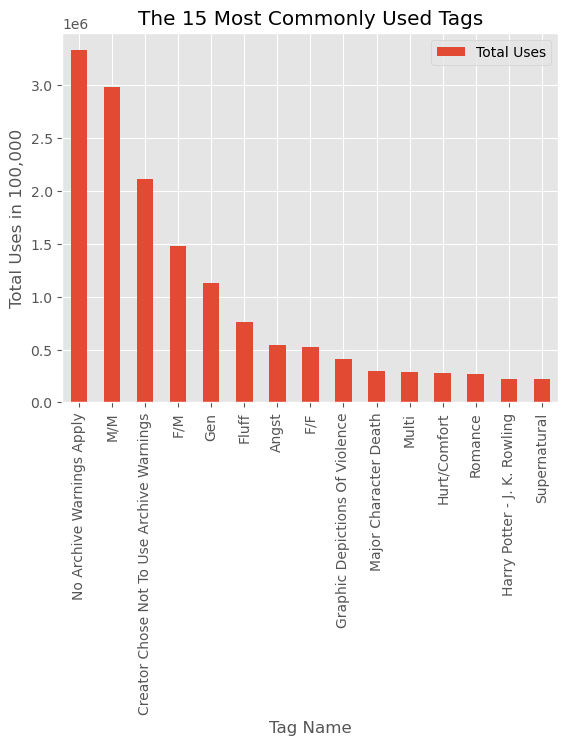

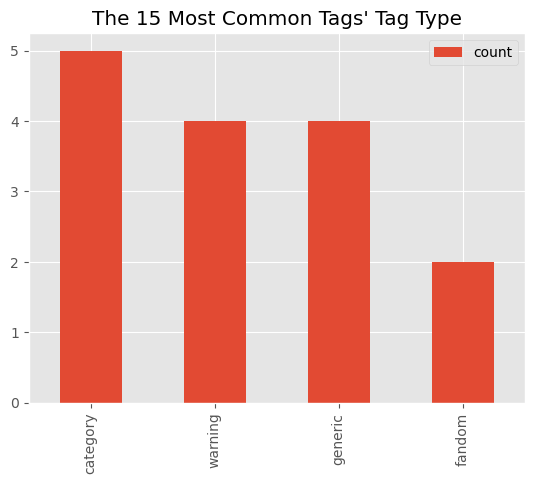

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

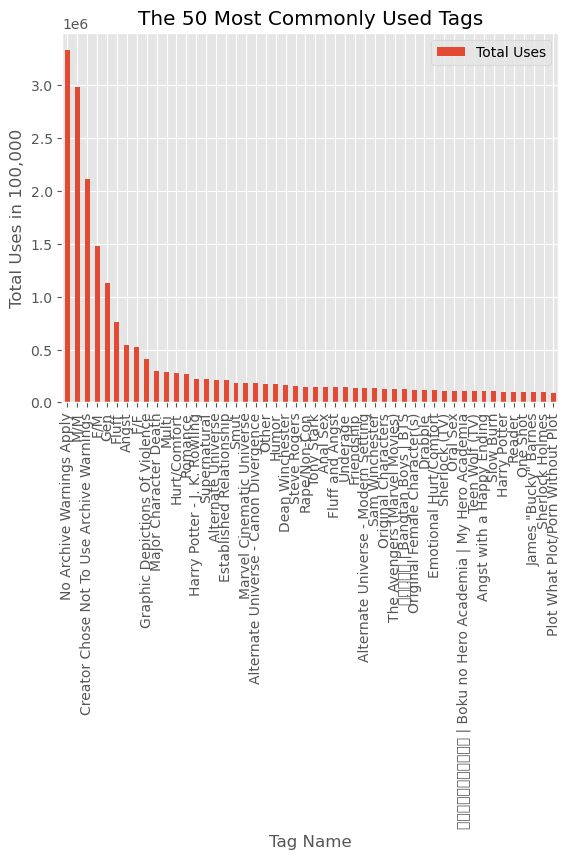

In [1]:
# THIS CELL WILL NOT RUN CORRECTLY

import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Top Tags looks at tags that have been used at least 5000 times.
top_tags = pd.read_csv("top_tags.csv")
tag_usage = pd.read_csv("top_tags_names.csv")

top_50 = tag_usage[:50]
top_10 = tag_usage[:15]

# Function to graph our data
def plot_name(df):
    df.plot(kind="bar",
               y = "Total Uses")
    plt.xticks(df.index.to_list(), df["Tag Name"].tolist())
    
       
plot_name(top_10)
plt.title(f"The 15 Most Commonly Used Tags")
plt.xlabel("Tag Name")
plt.ylabel("Total Uses in 100,000",rotation=90)
plt.show()

# Top 10 Tag Type

tag_type = top_10["Tag Type"].value_counts().to_frame().reset_index()
tag_type.plot(kind = "bar")
plt.title("The 15 Most Common Tags' Tag Type")
plt.xticks(tag_type.index.to_list(), tag_type["Tag Type"].tolist())

plt.show()

plot_name(top_50)
plt.title(f"The 50 Most Commonly Used Tags")
plt.xlabel("Tag Name")
plt.ylabel("Total Uses in 100,000",rotation=90)
plt.show()

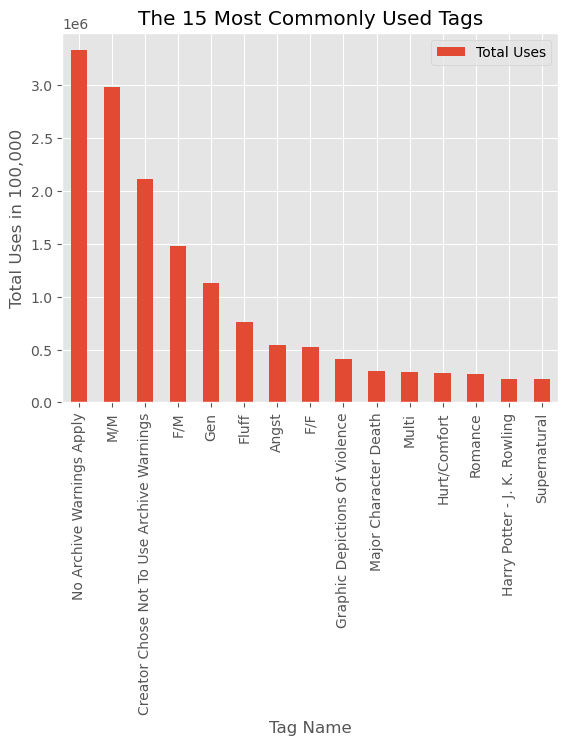

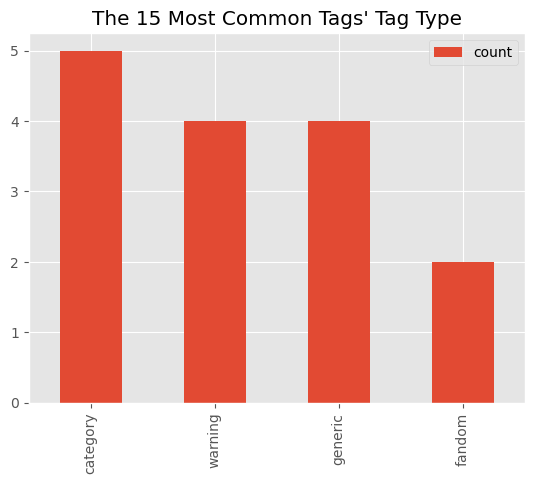

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

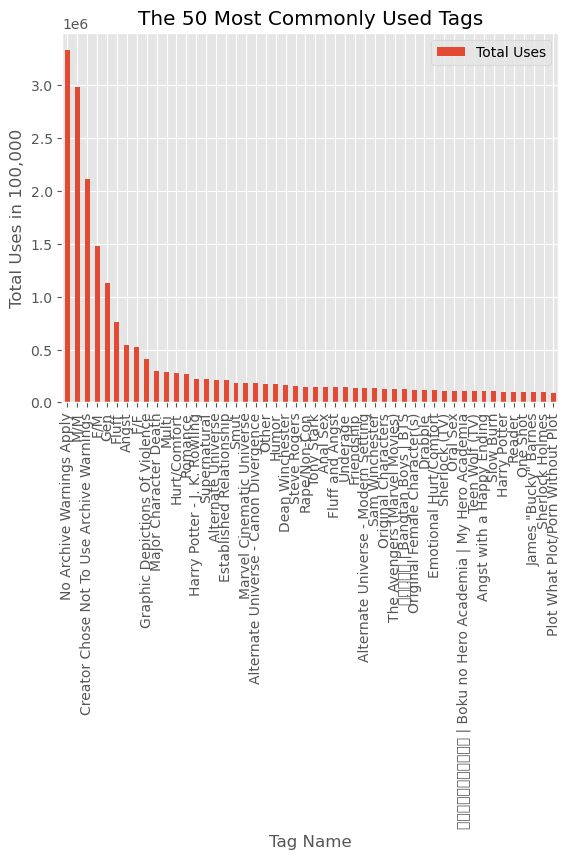

In [2]:
# RUN THIS CELL

import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

top_50 = pd.read_csv("most_common_reduced.csv")

top_10 = top_50[:15]

# Function to graph our data
def plot_name(df):
    df.plot(kind="bar",
               y = "Total Uses")
    plt.xticks(df.index.to_list(), df["Tag Name"].tolist())
    
       
plot_name(top_10)
plt.title(f"The 15 Most Commonly Used Tags")
plt.xlabel("Tag Name")
plt.ylabel("Total Uses in 100,000",rotation=90)
plt.show()

# Top 10 Tag Type

tag_type = top_10["Tag Type"].value_counts().to_frame().reset_index()
tag_type.plot(kind = "bar")
plt.title("The 15 Most Common Tags' Tag Type")
plt.xticks(tag_type.index.to_list(), tag_type["Tag Type"].tolist())

plt.show()

plot_name(top_50)
plt.title(f"The 50 Most Commonly Used Tags")
plt.xlabel("Tag Name")
plt.ylabel("Total Uses in 100,000",rotation=90)
plt.show()

The top 15 tags on AO3 around mid 2020 served many different purposes. We see that 5 of the top 15 tags deal with relationships in the work. As found in toastystats analysis, M/M fanfiction is most popular, with F/M works occuring half as much as M/M pairings. Four of the most popular tags described the tone or genre of a story, and only two of our top 15 tags were specific fandoms. The two fandoms with the most works Harry Potter, and Supernatural. Remember this, as it will come into play when we look at what tags occur most in highly liked stories. 

When we look at the top 50 tags, we see that they still do not include any specific character pairing. This was interesting to me, as there are quite a few pairings that come to mind when people mention fanfiction: Harry Potter/Draco Malfoy and Hermione Granger/Draco Malfoy being two well known fan pairings. There were also no specific NSFW tags in the top 15. However, some were included in the top 50 tags, which may add support to the perception that fanfiction is explicit. 

### Common Tags Within Fandoms

Knowing the tags used commonly overall is helpful in making general claims about fanfiction. However, we want to know if tags were specific to different fandoms. We decided to do a small sampling of the largest 20 fandoms, as we did not want to spend too much time looking into each fandom's most common tags. 

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

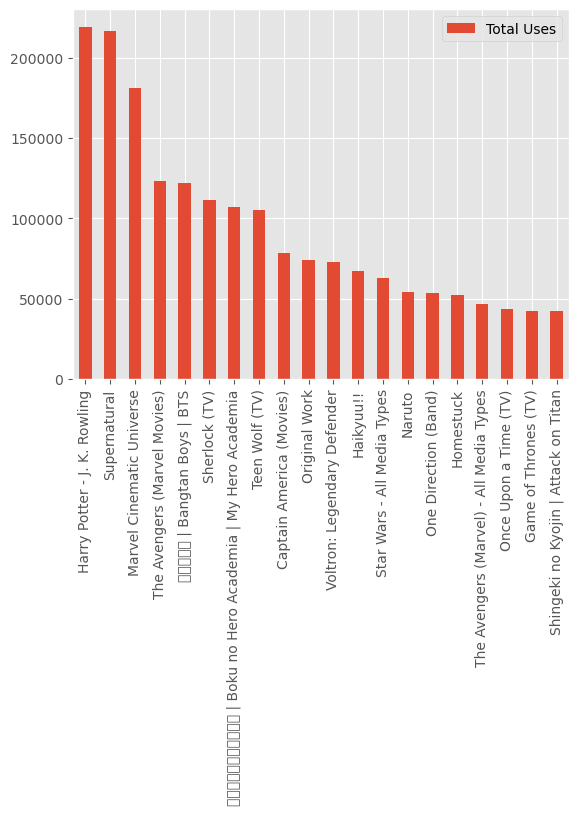

In [4]:
# THIS CELL WILL NOT RUN CORRECTLY

fandoms = tag_usage.copy(deep=True)
fandoms = fandoms[fandoms["Tag Type"] == "fandom"].reset_index()
fan_10 = fandoms[:20]

fan_10.plot(kind="bar",
           y = "Total Uses")
plt.xticks(fan_10.index.to_list(), fan_10["Tag Name"].tolist())
plt.show()

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

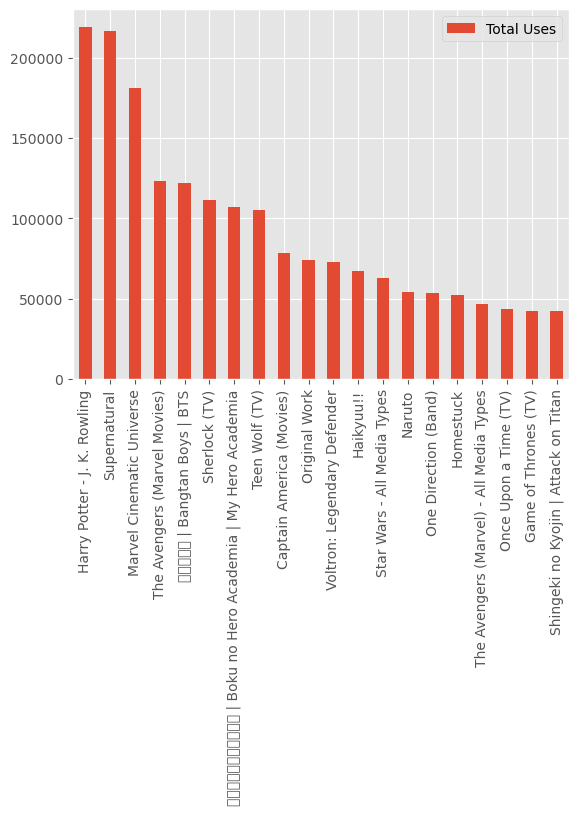

In [10]:
# RUN THIS CELL

fan_10 = pd.read_csv("top_fandoms.csv")
fan_10.plot(kind="bar",
           y = "Total Uses")
plt.xticks(fan_10.index.to_list(), fan_10["Tag Name"].tolist())
plt.show()

We see that the top three fandoms have at least 50,000 more works than the other fandoms shown. Note that Teen Wolf has barely 100,000 works; this will be important later.

### Most Common Tags in the Largest Fandoms

Now that we know the most common fandoms, we want to see if these fandoms have similar popular tags. We grab the 40 most common tags from each fandom, and count how many fandoms each occurs in. Out of all these tags, we then graph the top 20 tags that appear in our fandoms. We include our original code first, and code with a smaller file that will show our findings. 

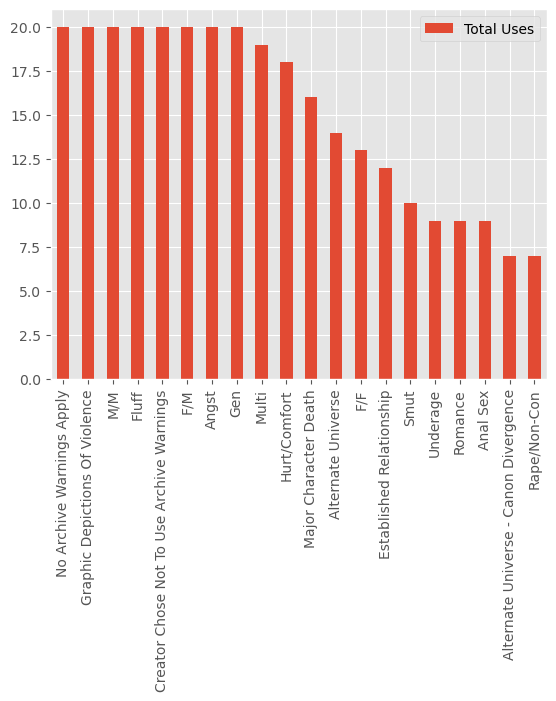

In [9]:
# THIS CELL WILL NOT RUN CORRECTLY

def sort_tags(df):
    tag_count = df["tagId"].value_counts().to_frame("Total Uses").reset_index()
    for iden in tag_count["tagId"]:
        tags = tag_count[tag_count["tagId"] == iden].reset_index()
        #print(tags)
        off_ind = tags.loc[0, "index"]
        
        tag_ind = df[df["tagId"] == iden].reset_index()
        tag_name = tag_ind.loc[0, "name"]
        tag_type = tag_ind.loc[0, "type"]
        
        tag_count.loc[off_ind, "Tag Name"] = tag_name
        tag_count.loc[off_ind, "Tag Type"] = tag_type
       
    return tag_count 
        
fan_tags_list = []
    
for tag in fan_10["tagId"].tolist():
    
    story_fan = top_tags[top_tags["tagId"] == tag]
    story_fan = story_fan["storyId"].tolist() 
# Help with isin: https://www.geeksforgeeks.org/python-pandas-dataframe-isin/
    fan_assess = top_tags["storyId"].isin(story_fan)
    fan_all = top_tags[fan_assess]
    fan_all = sort_tags(fan_all)
    #no_ships = remove_char_rel(fan_all)
    no_ships = fan_all[:40]
    fan_tags_list.append(no_ships)

pop_tags = {}

for fandom in fan_tags_list:
    for tag in fandom["tagId"]:
        if tag in pop_tags:
            pop_tags[tag] += 1
        else:
            pop_tags[tag] = 1


pop_tags_df = pd.DataFrame({
    "tagId": pop_tags.keys(),
    "Total Uses": pop_tags.values()
})

for iden in pop_tags_df["tagId"]:
    tags = pop_tags_df[pop_tags_df["tagId"] == iden].reset_index()
    off_ind = tags.loc[0, "index"]
    
    tag_ind = top_tags[top_tags["tagId"] == iden].reset_index()
    tag_name = tag_ind.loc[0, "name"]
    tag_type = tag_ind.loc[0, "type"]
   
    pop_tags_df.loc[off_ind, "Tag Name"] = tag_name
    pop_tags_df.loc[off_ind, "Tag Type"] = tag_type

pop_tags_df = pop_tags_df.sort_values("Total Uses", ascending=False).reset_index()
top_20 = pop_tags_df.iloc[:20]

plot_name(top_20)

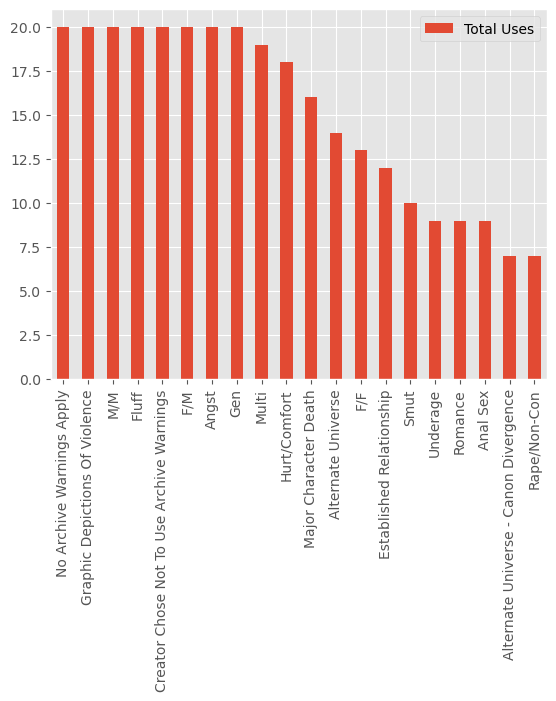

In [12]:
# RUN THIS CELL

top_20 = pd.read_csv("fandom_common.csv")
plot_name(top_20)

We see that many of the most common tags within our 20 fandoms are very similar to the most common tags from all fandoms. However, the top 20 here contain some NSFW tags. 

### Most Common Tags in Popular Stories

While it is interesting to look at the most commonly used tags, our earlier analysis has shown that the most popular works take up a very small subset of the total number of works. To see if these popular works have any shared tags, we will have to sort our data in a unique way. The majority of the coding for this will be included in our appendix. In order to simplify our calculations, we assume that kudos, or likes, are a good measure of popularity.

After sorting, we then save a pdf of tags only from the 10000 most liked works. Below are the ten most common of these tags.

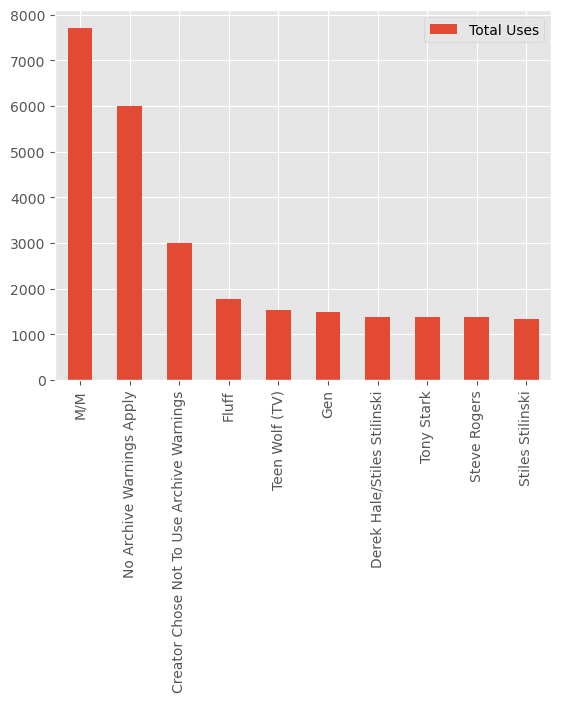

In [13]:
# THIS CELL WILL NOT RUN CORRECTLY

top_pop_tags = pd.read_csv("all_pop_tags.csv")
top_top_10 = top_pop_tags[:10]
plot_name(top_top_10)

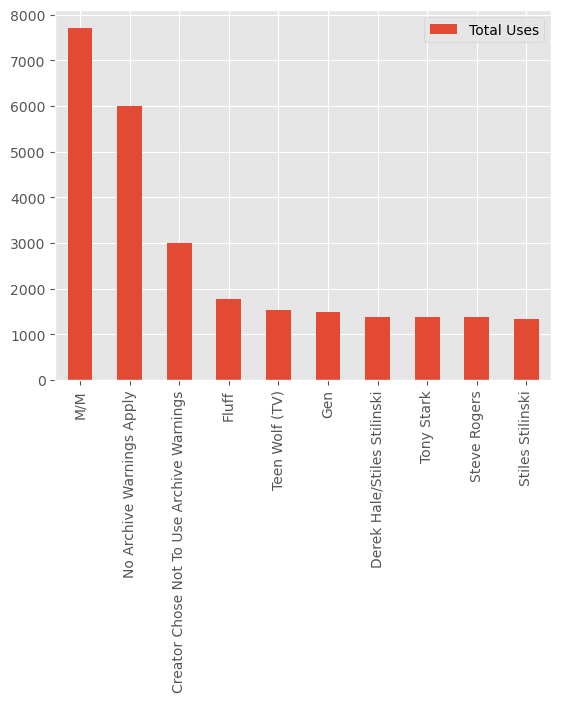

In [19]:
# RUN THIS CELL

top_top_10 = pd.read_csv("top_pop_tags.csv")
plot_name(top_top_10)

We note that the most common tag in popular works is also very common in all works: M/M relationships. However, unlike in all works, the ten most common tags here do not include any other romantic relationship types. 
We also see that the most popular fandom was not in the 5 most common fandoms. In fact, four of the most popular tags are related to the Teen Wolf fandom. 

### Predicting Popularity With Tags

With this note, we wondered if there was any correlation between these top tags, and the kudos a work receives. Our goal in studying this is to create a linear regression model that can predict a works popularity based on the tags associated with it.

We again have sorting steps that will be available in our extra findings, but for now we just imported a condensed file for quick processing. 

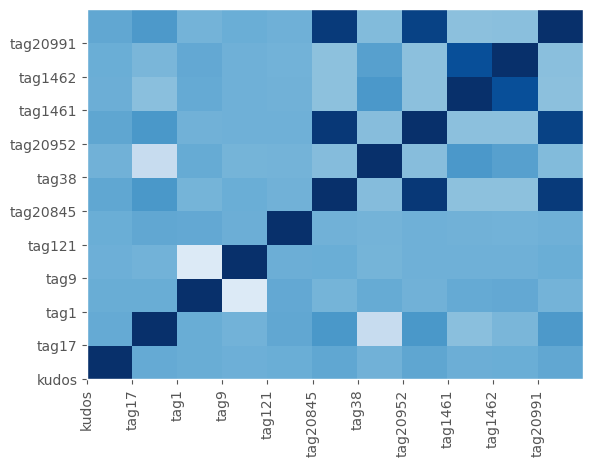

,kudos,tag17,tag1,tag9,tag121,tag20845,tag38,tag20952,tag1461,tag1462,tag20991
kudos,1.000000,0.036275,0.011898,-0.010403,0.001388,0.065122,-0.024369,0.076865,-0.002340,0.003846,0.059342
tag17,0.036275,1.000000,0.012198,-0.034232,0.055340,0.197904,-0.510283,0.196261,-0.151215,-0.074655,0.181207
tag1,0.011898,0.012198,1.000000,-0.728754,0.050557,-0.048025,0.029206,-0.025630,0.033773,0.049000,-0.039751
tag9,-0.010403,-0.034232,-0.728754,1.000000,-0.005623,0.006010,-0.050154,-0.015885,-0.018049,-0.016092,0.003670
tag121,0.001388,0.055340,0.050557,-0.005623,1.000000,-0.027576,-0.044969,-0.019966,-0.024278,-0.035593,-0.017100
tag20845,0.065122,0.197904,-0.048025,0.006010,-0.027576,1.000000,-0.129235,0.937104,-0.169657,-0.169143,0.919904
tag38,-0.024369,-0.510283,0.029206,-0.050154,-0.044969,-0.129235,1.000000,-0.137007,0.192588,0.120956,-0.115088
tag20952,0.076865,0.196261,-0.025630,-0.015885,-0.019966,0.937104,-0.137007,1.000000,-0.161251,-0.160770,0.864624
tag1461,-0.002340,-0.151215,0.033773,-0.018049,-0.024278,-0.169657,0.192588,-0.161251,1.000000,0.760938,-0.156439
tag1462,0.003846,-0.074655,0.049000,-0.016092,-0.035593,-0.169143,0.120956,-0.160770,0.760938,1.000000,-0.155963


In [20]:
num_data_stuff = pd.read_csv("corr_kudos.csv")

corr_data = num_data_stuff.copy(deep=True)
corr_data = corr_data[corr_data.columns[corr_data.columns.isin([ "kudos","tag17", "tag1", "tag9", "tag121", "tag20845", "tag38", "tag20952", "tag1461", "tag1462", "tag20991"])]]

corred_data = corr_data.corr()
heatmap = plt.pcolor(corred_data, cmap=plt.cm.Blues, vmin=-1, vmax=1)
plt.xticks(ticks=range(len(corr_data.columns)),labels=corred_data.columns,  rotation=90)
plt.yticks(ticks=range(len(corr_data.columns)),labels=corred_data.columns)
plt.show()

corred_data

From our correlation heatmap, we see that the strongest correlations actually exist between tags themselves, rather than between any specific tag and kudos. By looking at the numbers in the correlation matrix, we see that the highest correlations to kudos exist between tag 20845, 20952, and 20991. We now will take these tags, and perform ordinary least squares regression to see if we can use some combination of these tags to come up with a good model for kudos. 

In [21]:
import statsmodels.formula.api as sm  

most_corr = corr_data[corr_data.columns[corr_data.columns.isin(["kudos", "tag20845", "tag20952", "tag20991"])]]

tag_1 = top_top_10[top_top_10["tagId"]== 20845].reset_index()
tag_2 = top_top_10[top_top_10["tagId"]== 20952].reset_index()
tag_3 = top_top_10[top_top_10["tagId"]== 20991].reset_index()
nam_most_corr = most_corr.rename(columns={"tag20845": tag_1.loc[0, "Tag Name"], 
                                     "tag20952": tag_2.loc[0, "Tag Name"],
                                      "tag20991": tag_3.loc[0, "Tag Name"]})
nam_most_corr

,kudos,Teen Wolf (TV),Derek Hale/Stiles Stilinski,Stiles Stilinski
0,84819.0,0.0,0.0,0.0
1,50663.0,0.0,0.0,0.0
2,40988.0,0.0,0.0,0.0
3,36830.0,0.0,0.0,0.0
4,36759.0,1.0,1.0,1.0
...,...,...,...,...
9867,3245.0,1.0,1.0,1.0
9868,3245.0,0.0,0.0,0.0
9869,3244.0,0.0,0.0,0.0
9870,3244.0,0.0,0.0,0.0


For our models to work, we cannot rename our tags right now. We will do that last.

In [22]:
# first_model = sm.ols(formula=f"kudos ~ tag20845", data=most_corr).fit()
# print(first_model.summary())

model_2 = sm.ols(formula="kudos ~ tag20952", data=most_corr).fit()
print(model_2.summary())

# model_3 = sm.ols(formula="kudos ~ tag20991", data=most_corr).fit()
# print(model_3.summary())

model_4 = sm.ols(formula="kudos ~ tag20952 + tag20845", data=most_corr).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  kudos   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     58.66
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           2.05e-14
Time:                        23:21:19   Log-Likelihood:                -93015.
No. Observations:                9872   AIC:                         1.860e+05
Df Residuals:                    9870   BIC:                         1.860e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5319.2139     32.450    163.918      0.0

After looking at models, we see that tag20952, or "Teen Wolf (TV)", has the highest r^2 value, as well as a low p score. So, we will graph this, as it is our best model.

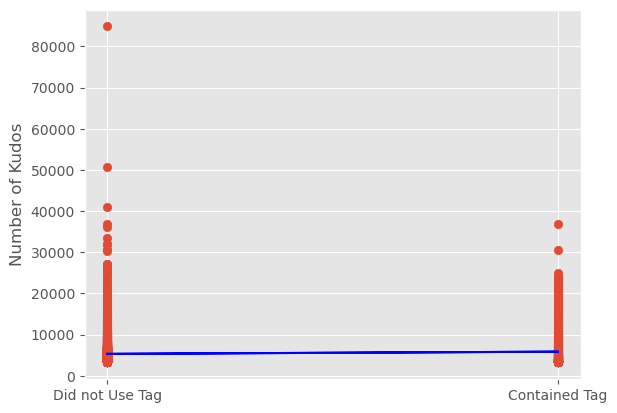

In [23]:
data_renam = corr_data.rename(columns={"tag20845": tag_1.loc[0, "Tag Name"], 
                                     "tag20952": tag_2.loc[0, "Tag Name"],
                                      "tag20991": tag_3.loc[0, "Tag Name"]})
plt.scatter(data_renam["Teen Wolf (TV)"].tolist(), data_renam["kudos"].tolist())
plt.xticks([0,1], labels= ["Did not Use Tag", "Contained Tag"])
plt.ylabel("Number of Kudos", rotation=90)
plt.plot(data_renam["Teen Wolf (TV)"].tolist(),first_model.predict(),c='b')
plt.show()

Our graph shows that our there is a slight increase in kudos when a work has the tag "Teen Wolf (TV)", but it is not a significant increase. The line does not fit our data at all.

Since the correlation was not strong between any of these tags and kudos, it makes sense that our tag models are inaccurate. From this we cann conclude that correlation between two items will not mean they can be used to accurately predict one another. 
That being said, the most common popular tags do surround the Teen Wolf fandom. There is some correlation there, and it does suggest that readers prior to mid 2020 enjoyed stories in this fandom. However, as mentioned earlier, kudos could be effected by the date a work was released, the quality of the writing, and other factors. These other factors may have a more significant impact on a work's predicted kudos. 

### Evaluation

Our project successfully completed many of our milestones. We collected, cleaned, and analyzed a large amount of data in a variety of ways and along the way discovered many interesting things about fanfiction.

However, we did not succeed in every goal. In our project proposal, we stated our desire to analyze how the number of fanfictions on the site AO3 changed over time, however this analysis produced very strange results – like works being uploaded in 1980, decades before the site was available, so we didn’t include this code in our analysis. One possibility behind this oddity is that AO3 lets users manually select the date uploaded when posting a fan work to the site, so if people manually selected 1980 as their publishing date when uploading, that would explain the oddities in the data.

Another thing that we wanted to do was create a sentiment analysis of the text and see if positive or negative sentiment were correlated with popularity, however none of our group members knew much about sentiment analysis and the basic version we covered in class seemed to be too basic for our purposes. So, we elected not to perform this analysis.

Our project comes with obvious limitations. First, we analyzed only a portion of the fanfiction available on archiveofourown, and the archive only has a portion of the total quantity of fan works made. Thus, it is possible that our analysis will not generalize to fandom as a whole. That said, we have quite a substantial sample – over 6 million works – and no strong reason to believe that our sample is statistically different from fandom as a whole.

A second limitation is the risk of confounding. To illustrate this risk, we found that on average the longer a work is the more popular it is. However, this does not mean that length causes a work to be more popular. It could be that a third thing – perhaps writing quality or enthusiasm on the author’s part for the story – produces both length and popularity. It could also be that as a work gets more popular, the fame motivates the author to write more of it – an example of reverse causation. Similar confounding or reverse causation stories could be told for all of the statistical differences we found. However, since we make no claim that we have identified causation, only correlation, our statistical analysis is on firmer ground.

A third limitation is our project’s reliance on the web-scraping efforts of CoolCat, the reddit user who collected and publicized the data we use for analysis. If they made systemic errors in data collection, organization, or storage those errors would very likely transfer over to our own analysis. Spot-checking the data for particular works on the archive itself showed that CoolCat’s data is accurate, as far as we can tell, however no systematic evidence of accuracy was gathered.

## Ethical Data Concerns

From the project proposal, our concerns were threefold: 
- First, that the authors of the fanworks analyzed did not consent to their data being collected.
- Second, that personal information could be discovered.
- Third, that our analysis could contribute to the poor public perception of fanfiction.

After project completion, we have a better perspective on these ethical risks:
- Firstly, while authors were not contacted to ask for their consent, the works that were scraped and have usable data were all unrestricted, meaning they were publicly accessible by anyone visiting AO3. This data was also collected and shared publically by the CoolCat; we did not scrape the data ourselves. As mentioned in our proejct proposal, since the release of AI tools such as Chat GPT, some AO3 authors have been upset that machine learning could be used on their works and used to create "new" fan works. Our project will never try to take the gathered text and reproduce a similar work.
- Secondly, while there may be personal information in the data we are looking at, our data analysis has not uncovered any of this information.
- Thirdly, while fanfiction does have a negative reputation in the public eye, we still think that since we are not publishing our analysis in public that our project will have little reputational impact regardless of its findings. That being said, we have discovered that in our sample, more explicit/mature works are more popular among fanfic readers. This reinforces the popular perception of fanfic-as-porn. However, we also found that a majority of works in our sample are rated "General" or "Teen", implying that most fanfic written is not pornographic, even if more explicit works are more popular.


## Summary

Using data from a web-scrapping project, we dowloanded information about millions of fan-works published on Archive Of Our Own. Then, after cleaning and converting the data into csv format, we conducted a variety of statistical tests on the "meta-data" of each fan-work, as presented in the **Analysis/Methods/Results** section. We also analyzed the tags associated with each fan-work.

From this analysis we have come to several conclusions:
- The different notions of popularity - hits, kudos, comments, and bookmarks - are positively correlated.
- Fanworks tend to be short, mostly under 5000 words, although there is high variance.
- Most works are published in English, with Chinese and Russian distant runners-up.
- Longer works tend to be more popular.
- Explicit works tend to be more popular.
- Unfinished works tend to be more popular.
- Works in English tend to be more popular.
- The distribution of popularity is highly unequal, with the most popular works recieving a highly disproportionate number of the total hits, kudos, comments, and bookmarks.
- There are common tags associated with many popular works, and these tags differ from the most commonly used tags.
- A model using tags alone will not be able to accurately predict the kudos a work will receive. Factors like comments and bookmarks are much better predictors of kudos. 